In [20]:
#unique_age_milestones = df['Dimension'].unique()


In [21]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.factorplots import interaction_plot
from scipy.stats import levene



In [22]:
df = pd.read_csv("Datasets/Vaccination_Coverage_among_Young_Children__0-35_Months__20241101.csv")

In [23]:
# Define the state-to-region mapping for the 9 census regions
state_to_region = {
    # Middle Atlantic
    'New York': 'Middle Atlantic', 'NY-Rest of state': 'Middle Atlantic', 'NY-City of New York': 'Middle Atlantic', 
    'New Jersey': 'Middle Atlantic', 'Pennsylvania': 'Middle Atlantic', 
    'PA-Philadelphia': 'Middle Atlantic', 'PA-Rest of state': 'Middle Atlantic',

    # New England
    'Vermont': 'New England', 'New Hampshire': 'New England', 'Massachusetts': 'New England', 
    'Connecticut': 'New England', 'Rhode Island': 'New England', 'Maine': 'New England',

    # East North Central
    'Indiana': 'East North Central', 'Illinois': 'East North Central', 'Michigan': 'East North Central', 
    'Ohio': 'East North Central', 'Wisconsin': 'East North Central', 
    'IL-City of Chicago': 'East North Central', 'IL-Rest of state': 'East North Central',

    # West North Central
    'Iowa': 'West North Central', 'Kansas': 'West North Central', 'Minnesota': 'West North Central',
    'Missouri': 'West North Central', 'Nebraska': 'West North Central', 
    'North Dakota': 'West North Central', 'South Dakota': 'West North Central',

    # South Atlantic
    'Delaware': 'South Atlantic', 'District of Columbia': 'South Atlantic', 'Florida': 'South Atlantic', 
    'Georgia': 'South Atlantic', 'Maryland': 'South Atlantic', 'North Carolina': 'South Atlantic', 
    'South Carolina': 'South Atlantic', 'Virginia': 'South Atlantic', 'West Virginia': 'South Atlantic',

    # East South Central
    'Alabama': 'East South Central', 'Kentucky': 'East South Central', 
    'Mississippi': 'East South Central', 'Tennessee': 'East South Central', 

    # West South Central
    'Arkansas': 'West South Central', 'Louisiana': 'West South Central', 'Oklahoma': 'West South Central', 
    'Texas': 'West South Central', 'TX-City of Houston': 'West South Central', 
    'TX-Rest of state': 'West South Central', 'TX-Dallas County': 'West South Central', 
    'TX-Bexar County': 'West South Central', 'TX-El Paso County': 'West South Central', 
    'TX-Hidalgo County': 'West South Central', 'TX-Tarrant County': 'West South Central',

    # Mountain
    'Arizona': 'Mountain', 'Colorado': 'Mountain', 'Idaho': 'Mountain', 
    'New Mexico': 'Mountain', 'Montana': 'Mountain', 'Utah': 'Mountain', 
    'Nevada': 'Mountain', 'Wyoming': 'Mountain',

    # Pacific
    'Alaska': 'Pacific', 'California': 'Pacific', 'Hawaii': 'Pacific', 
    'Oregon': 'Pacific', 'Washington': 'Pacific'
}


In [24]:
# Filter dataset for DTaP vaccine, relevant years, and rows where 'Dimension Type' is 'Age'
df_filtered = df[
    (df['Vaccine'] == 'DTaP') & 
    (df['Birth Year/Birth Cohort'].str.contains('2020|2021', na=False)) & 
    (df['Dimension Type'] == 'Age')
]


In [25]:

# Map Census Region and handle any unmapped entries as 'Unknown'
df_filtered['Census Region'] = df_filtered['Geography'].map(state_to_region).fillna('Unknown')

# Filter out rows with 'Unknown' regions if they exist
df_filtered = df_filtered[df_filtered['Census Region'] != 'Unknown']

# Extract the age in months from the 'Dimension' column
df_filtered['Age Milestone (months)'] = df_filtered['Dimension'].str.extract(r'(\d+)').astype(float)

# Drop any rows with missing values in relevant columns
df_filtered = df_filtered.dropna(subset=['Age Milestone (months)', 'Census Region', 'Estimate (%)'])

# Convert Estimate (%) to numeric if not already
df_filtered['Estimate (%)'] = pd.to_numeric(df_filtered['Estimate (%)'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['Estimate (%)'])



C:\Users\16692\AppData\Local\Temp\ipykernel_1864\357962754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Census Region'] = df_filtered['Geography'].map(state_to_region).fillna('Unknown')


In [26]:
# Run Two-Way ANOVA for Region and Age with interaction
model = ols('Q("Estimate (%)") ~ Q("Census Region") + Q("Age Milestone (months)") + Q("Census Region"):Q("Age Milestone (months)")', data=df_filtered).fit()
anova_results = anova_lm(model, typ=2)

# Display ANOVA table for interpretation
print("\nANOVA Results:\n", anova_results)

# Check if p-value for Census Region is significant (< 0.01) to justify running Tukey's test
if anova_results.loc['Q("Census Region")', 'PR(>F)'] < 0.01:
    tukey = pairwise_tukeyhsd(endog=df_filtered['Estimate (%)'], groups=df_filtered['Census Region'], alpha=0.01)
    print("\nTukey HSD Test Results:\n", tukey)

# Additional output for F and p-values for easier reference
print("\nF and p-values for each effect in the ANOVA:")
for effect in ['Q("Census Region")', 'Q("Age Milestone (months)")', 'Q("Census Region"):Q("Age Milestone (months)")']:
    f_value = anova_results.loc[effect, 'F']
    p_value = anova_results.loc[effect, 'PR(>F)']
    print(f"{effect} - F-value: {f_value}, p-value: {p_value}")


ANOVA Results:
                                                        sum_sq      df  \
Q("Census Region")                               11559.211081     8.0   
Q("Age Milestone (months)")                      24090.388108     1.0   
Q("Census Region"):Q("Age Milestone (months)")     701.836726     8.0   
Residual                                        154580.822418  2382.0   

                                                         F        PR(>F)  
Q("Census Region")                               22.265085  4.934921e-33  
Q("Age Milestone (months)")                     371.218781  5.428739e-77  
Q("Census Region"):Q("Age Milestone (months)")    1.351862  2.130543e-01  
Residual                                               NaN           NaN  

Tukey HSD Test Results:
              Multiple Comparison of Means - Tukey HSD, FWER=0.01             
      group1             group2       meandiff p-adj   lower    upper  reject
------------------------------------------------------------

In [28]:
# Verify Conditions for Two-Way ANOVA
print("\n**Verifying Conditions for Two-Way ANOVA**")

# 1. Equal Variance Check (Levene's Test)
print("\nChecking Equal Variance Across Regions:")
grouped_data_region = [df_filtered[df_filtered['Census Region'] == region]['Estimate (%)'] 
                       for region in df_filtered['Census Region'].unique()]
levene_stat_region, levene_p_region = levene(*grouped_data_region)
print(f"Levene's Test (Regions): Statistic = {levene_stat_region:.4f}, p-value = {levene_p_region:.4e}")
if levene_p_region > 0.01:
    print("Equal variance assumption across regions is met.")
else:
    print("Equal variance assumption across regions is violated.")

print("\nChecking Equal Variance Across Age Milestones:")
grouped_data_age = [df_filtered[df_filtered['Age Milestone (months)'] == age]['Estimate (%)'] 
                    for age in df_filtered['Age Milestone (months)'].unique()]
levene_stat_age, levene_p_age = levene(*grouped_data_age)
print(f"Levene's Test (Age Milestones): Statistic = {levene_stat_age:.4f}, p-value = {levene_p_age:.4e}")
if levene_p_age > 0.01:
    print("Equal variance assumption across age milestones is met.")
else:
    print("Equal variance assumption across age milestones is violated.")


**Verifying Conditions for Two-Way ANOVA**

Checking Equal Variance Across Regions:
Levene's Test (Regions): Statistic = 3.3080, p-value = 9.1420e-04
Equal variance assumption across regions is violated.

Checking Equal Variance Across Age Milestones:
Levene's Test (Age Milestones): Statistic = 218.6836, p-value = 6.1821e-223
Equal variance assumption across age milestones is violated.


In [32]:
# 2. Display Groups Being Compared
print("\nGroups Being Compared:")
print("Regions:", df_filtered['Census Region'].unique())
print("Age Milestones (months):", sorted(df_filtered['Age Milestone (months)'].unique()))




Groups Being Compared:
Regions: ['West North Central' 'South Atlantic' 'Middle Atlantic' 'Pacific'
 'East North Central' 'West South Central' 'Mountain' 'East South Central'
 'New England']
Age Milestones (months): [3.0, 5.0, 7.0, 13.0, 19.0, 24.0, 35.0]


In [30]:
# 3. Display Sample Sizes
print("\nSample Sizes for Each Region:")
region_sample_sizes = df_filtered.groupby('Census Region')['Estimate (%)'].count()
print(region_sample_sizes)

print("\nSample Sizes for Each Age Milestone (months):")
age_sample_sizes = df_filtered.groupby('Age Milestone (months)')['Estimate (%)'].count()
print(age_sample_sizes)

print("\nSample Sizes for Each Region-Age Combination:")
region_age_sample_sizes = df_filtered.groupby(['Census Region', 'Age Milestone (months)'])['Estimate (%)'].count()
print(region_age_sample_sizes)

# Summarize Assumptions
print("\n**Summary of Assumptions for ANOVA**")
print(f"Equal Variances Across Regions: {'Met' if levene_p_region > 0.01 else 'Violated'}")
print(f"Equal Variances Across Age Milestones: {'Met' if levene_p_age > 0.01 else 'Violated'}")
print("Sample sizes for each group are displayed. Ensure sufficient data (e.g., n > 45 per group).")


Sample Sizes for Each Region:
Census Region
East North Central    280
East South Central    160
Middle Atlantic       280
Mountain              320
New England           240
Pacific               200
South Atlantic        360
West North Central    280
West South Central    280
Name: Estimate (%), dtype: int64

Sample Sizes for Each Age Milestone (months):
Age Milestone (months)
3.0     240
5.0     240
7.0     240
13.0    240
19.0    480
24.0    480
35.0    480
Name: Estimate (%), dtype: int64

Sample Sizes for Each Region-Age Combination:
Census Region       Age Milestone (months)
East North Central  3.0                       28
                    5.0                       28
                    7.0                       28
                    13.0                      28
                    19.0                      56
                                              ..
West South Central  7.0                       28
                    13.0                      28
                   

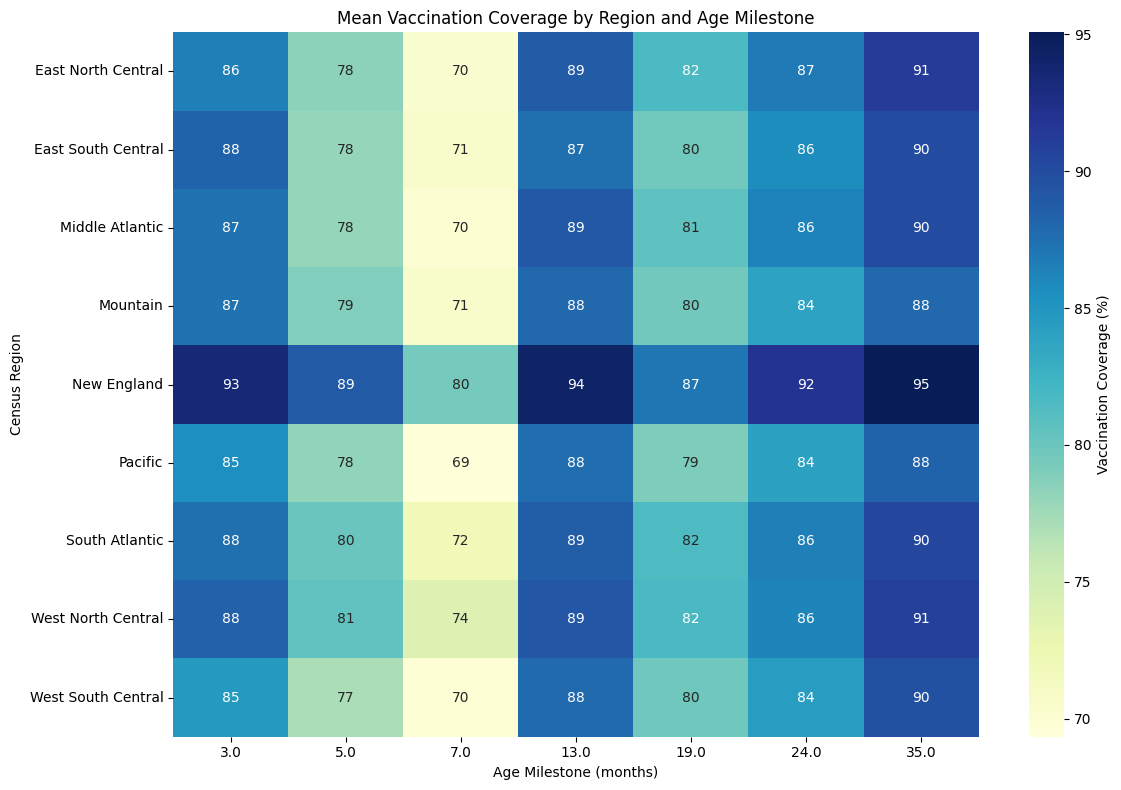

In [31]:
# Pivot data for heatmap
heatmap_data = df_filtered.pivot_table(
    values='Estimate (%)', 
    index='Census Region', 
    columns='Age Milestone (months)', 
    aggfunc='mean'
)

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Vaccination Coverage (%)'})
plt.title('Mean Vaccination Coverage by Region and Age Milestone')
plt.xlabel('Age Milestone (months)')
plt.ylabel('Census Region')
plt.tight_layout()
plt.show()

